# Risk Parity Strategy with S&P500 9 sectors

# 1. Import & Definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
import seaborn as sns
import datetime

import statsmodels.api as sm
from scipy.optimize import minimize

C:\Users\joshu\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_style('darkgrid')

## 1.1 Data Import 

In [3]:
df_returns = pd.read_csv('input/snp500_sector_etf_2000_2017_monthly_WRDS_ver2.csv')

In [5]:
df_returns['date'] = '01' + df_returns['date'].str[2:]
df_returns.head()

,PERMNO,date,TICKER,COMNAM,CUSIP,HSICIG,PRC,RET,SHROUT,vwretd,ewretd
0,84398,01/01/2000,SPY,SPDR TRUST,78462F10,NaN,139.62500,-0.049362,27109,-0.039607,0.050642
1,84398,01/02/2000,SPY,SPDR TRUST,78462F10,NaN,137.43750,-0.015667,102670,0.031782,0.120481
2,84398,01/03/2000,SPY,SPDR TRUST,78462F10,NaN,150.37500,0.096832,102670,0.053499,-0.000464
3,84398,01/04/2000,SPY,SPDR TRUST,78462F10,NaN,145.09375,-0.035121,102670,-0.059527,-0.088473
4,84398,01/05/2000,SPY,SPDR TRUST,78462F10,NaN,142.81250,-0.015723,102670,-0.038870,-0.057337


In [6]:
df_returns['date'] = pd.to_datetime(df_returns['date'], format='%d/%m/%Y')

In [7]:
df_returns.head()

,PERMNO,date,TICKER,COMNAM,CUSIP,HSICIG,PRC,RET,SHROUT,vwretd,ewretd
0,84398,2000-01-01,SPY,SPDR TRUST,78462F10,NaN,139.62500,-0.049362,27109,-0.039607,0.050642
1,84398,2000-02-01,SPY,SPDR TRUST,78462F10,NaN,137.43750,-0.015667,102670,0.031782,0.120481
2,84398,2000-03-01,SPY,SPDR TRUST,78462F10,NaN,150.37500,0.096832,102670,0.053499,-0.000464
3,84398,2000-04-01,SPY,SPDR TRUST,78462F10,NaN,145.09375,-0.035121,102670,-0.059527,-0.088473
4,84398,2000-05-01,SPY,SPDR TRUST,78462F10,NaN,142.81250,-0.015723,102670,-0.038870,-0.057337


In [8]:
df_returns = df_returns.reset_index()
df_returns = df_returns.set_index(['date','TICKER'])

In [9]:
df_returns.head()

,,index,PERMNO,COMNAM,CUSIP,HSICIG,PRC,RET,SHROUT,vwretd,ewretd
date,TICKER,,,,,,,,,,
2000-01-01,SPY,0,84398,SPDR TRUST,78462F10,NaN,139.62500,-0.049362,27109,-0.039607,0.050642
2000-02-01,SPY,1,84398,SPDR TRUST,78462F10,NaN,137.43750,-0.015667,102670,0.031782,0.120481
2000-03-01,SPY,2,84398,SPDR TRUST,78462F10,NaN,150.37500,0.096832,102670,0.053499,-0.000464
2000-04-01,SPY,3,84398,SPDR TRUST,78462F10,NaN,145.09375,-0.035121,102670,-0.059527,-0.088473
2000-05-01,SPY,4,84398,SPDR TRUST,78462F10,NaN,142.81250,-0.015723,102670,-0.038870,-0.057337


In [10]:
df_returns = df_returns['RET']
df_returns.head()

date        TICKER
2000-01-01  SPY      -0.049362
2000-02-01  SPY      -0.015667
2000-03-01  SPY       0.096832
2000-04-01  SPY      -0.035121
2000-05-01  SPY      -0.015723
Name: RET, dtype: float64

In [11]:
df_returns = df_returns.unstack()
df_returns.head()

TICKER,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,
2000-01-01,-0.049362,-0.122281,0.008074,-0.029586,-0.081794,-0.061485,0.008820,-0.017768,-0.025291,-0.124245
2000-02-01,-0.015667,-0.100469,-0.042334,-0.107046,-0.055172,0.105068,-0.117014,-0.121538,-0.065387,-0.055715
2000-03-01,0.096832,0.100881,0.124355,0.182417,0.139096,0.083893,0.037603,0.109138,0.089950,0.141429
2000-04-01,-0.035121,-0.033220,-0.014925,0.009659,0.014446,-0.091847,0.053019,0.065459,-0.011717,-0.020822
2000-05-01,-0.015723,-0.031557,0.117424,0.022321,-0.004219,-0.103977,0.071329,-0.002194,-0.026804,-0.053980


In [12]:
df_sector = df_returns[['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 
                        'XLP', 'XLU', 'XLV', 'XLY']]
df_sector.head()

TICKER,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2000-01-01,-0.122281,0.008074,-0.029586,-0.081794,-0.061485,0.008820,-0.017768,-0.025291,-0.124245
2000-02-01,-0.100469,-0.042334,-0.107046,-0.055172,0.105068,-0.117014,-0.121538,-0.065387,-0.055715
2000-03-01,0.100881,0.124355,0.182417,0.139096,0.083893,0.037603,0.109138,0.089950,0.141429
2000-04-01,-0.033220,-0.014925,0.009659,0.014446,-0.091847,0.053019,0.065459,-0.011717,-0.020822
2000-05-01,-0.031557,0.117424,0.022321,-0.004219,-0.103977,0.071329,-0.002194,-0.026804,-0.053980


### 1.1.2 FamaFrench Model

In [14]:
df_ff = pd.read_csv('input/Fama-French-3-Factor-Model-Monthly-Data.CSV')
df_ff.head()

,date,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


In [15]:
df_ff['date'] = pd.to_datetime(df_ff['date'], format='%Y%m')
df_ff

,date,Mkt-RF,SMB,HML,RF
0,1926-07-01,2.96,-2.30,-2.87,0.22
1,1926-08-01,2.64,-1.40,4.19,0.25
2,1926-09-01,0.36,-1.32,0.01,0.23
3,1926-10-01,-3.24,0.04,0.51,0.32
4,1926-11-01,2.53,-0.20,-0.35,0.31
5,1926-12-01,2.62,-0.04,-0.02,0.28
6,1927-01-01,-0.06,-0.56,4.83,0.25
7,1927-02-01,4.18,-0.10,3.17,0.26
8,1927-03-01,0.13,-1.60,-2.67,0.30
9,1927-04-01,0.46,0.43,0.60,0.25


## 1.2 Function Definition

In [76]:
def calculate_portfolio_var(w, V):
    w          = np.matrix(w)
    CoVar      = df_sector.cov()
    V          = np.matrix(CoVar)
    bkt_var    = (w * V * w.T)
    
    return bkt_var

def calculate_risk_contribution(w, V):
    w     = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w, V))
    MRC   = V * w.T
    RC    = np.multiply(MRC, w.T) / sigma
    return RC

def risk_budget_objective(x, pars):
    V           = pars[0]   # covariance table
    x_t         = pars[1]   # risk target in percent of portfolio risk
    x           = np.matrix(x)  # asset weight
    sig_p       = np.sqrt(x * V * x.T)  # portfolio Sigma
    risk_target = np.asmatrix(np.multiply(sig_p, x_t))
    asset_RC    = calculate_risk_contribution(x, V)
    SSE         = sum(np.square(asset_RC - risk_target.T))[0, 0] * 1000 # sum of squred error
    return SSE

def total_weight_constraint(x):
    return np.sum(x) - 1.0

def long_only_constraint(x) :
    return x

def iter_covar(roll, w0, x_t, cons):
    x_results = []
    x_dates   = []
    
    for i in range(len(roll) // 9):
        single_row = roll[0:9]
        mini       = minimize(risk_budget_objective, w0, 
                              args    = [single_row.values, x_t.T],
                              method  = 'SLSQP', constraints = cons,
                              options = {'disp' : True})
        x_results.append(mini.x)
        x_dates.append(single_row.index[0][0])
        roll = roll.iloc[9:]
        
        print(mini.x)
        
    return [x_results, x_dates]


def list_to_df(it):
    first   = []
    second  = []
    third   = []
    fourth  = []
    fifth   = []
    sixth   = []
    seventh = []
    eighth  = []
    nineth  = []
    date    = []

    for i in it[0]:
        first.append(  i[0])
        second.append( i[1])
        third.append(  i[2])
        fourth.append( i[3])
        fifth.append(  i[4])
        sixth.append(  i[5])
        seventh.append(i[6])
        eighth.append( i[7])
        nineth.append( i[8])
        

    for i in it[1]:
        date.append(i)

    df = pd.DataFrame(
        {'date': date, 'XLB_wt' : first,   'XLE_wt' : second, 'XLF_wt' : third, 
                       'XLI_wt' : fourth,  'XLK_wt' : fifth,  'XLP_wt' : sixth, 
                       'XLU_wt' : seventh, 'XLV_wt' : eighth, 'XLY_wt' : nineth})
    
    return df


# 2. Main implementation

## 2.1 Initial Setting

In [77]:
rolling_size = 24  # rolling window period
wgt_init     = [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9]
w0           = np.matrix(wgt_init)
CoVar        = df_sector.cov()
V            = np.matrix(CoVar)

## 2.2 Optimization

In [78]:
x_t      = np.matrix([[1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9]]) # Target Risk Budgeting
cons     = ({'type':'eq',   'fun':total_weight_constraint}, 
            {'type':'ineq', 'fun':long_only_constraint})

#optimize_wgt = minimize(risk_budget_objective, w0, args=[V, x_t.T], 
#                        method = 'SLSQP', constraints = cons, options = {'disp' : True})

#print(optimize_wgt.x)

roll_rets  = df_sector.rolling(window=rolling_size)
roll_covar = roll_rets.cov().dropna()
df_weight  = list_to_df(iter_covar(roll_covar, w0, x_t, cons))

#df_weight.to_csv('df_weight.csv', sep=',')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00681126099550638
            Iterations: 8
            Function evaluations: 97
            Gradient evaluations: 8
[0.0824049  0.10841925 0.08955867 0.07219901 0.08513921 0.22091673
 0.15868077 0.09264012 0.09004134]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0054856159517090285
            Iterations: 8
            Function evaluations: 97
            Gradient evaluations: 8
[0.08798585 0.10416543 0.08902067 0.07316444 0.08440528 0.21478349
 0.15784774 0.09148724 0.09713985]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00046883550785151265
            Iterations: 10
            Function evaluations: 120
            Gradient evaluations: 10
[0.08493251 0.09109407 0.08856243 0.06621965 0.06574534 0.25090103
 0.17182586 0.08844378 0.09227534]
Optimization terminated successfully.    (Exit mode 0)
 

## 2.3 Weights Result

In [79]:
df_weight = df_weight.set_index('date')
df_weight = df_weight.shift(1).dropna() # next month rebalancing portfolio
#df_weight.sum(axis=1)

In [80]:
df_returns = df_returns.reset_index()
df_weight  = df_weight.reset_index()

# 3. DataFrame Aggregate

## 3.1 Sector Returns & RP-weight

In [81]:
df_RP = pd.merge(df_returns, df_weight, on='date', how='inner')
df_RP

,level_0,index,date,SPY,XLB,XLE,XLF,XLI,XLK,XLP,...,XLY,XLB_wt,XLE_wt,XLF_wt,XLI_wt,XLK_wt,XLP_wt,XLU_wt,XLV_wt,XLY_wt
0,24,24,2002-01-01,-0.009799,0.023343,-0.035581,-0.011407,-0.063177,-0.010833,-0.006693,...,0.032867,0.082405,0.108419,0.089559,0.072199,0.085139,0.220917,0.158681,0.092640,0.090041
1,25,25,2002-02-01,-0.017936,0.052920,0.034175,-0.017308,0.025048,-0.129907,0.021007,...,0.005416,0.087986,0.104165,0.089021,0.073164,0.084405,0.214783,0.157848,0.091487,0.097140
2,26,26,2002-03-01,0.033297,0.030725,0.088465,0.066125,0.027125,0.049090,0.016096,...,0.012717,0.084933,0.091094,0.088562,0.066220,0.065745,0.250901,0.171826,0.088444,0.092275
3,27,27,2002-04-01,-0.058156,-0.047237,-0.035999,-0.025414,-0.069016,-0.120905,-0.037165,...,-0.027963,0.080272,0.088478,0.097978,0.066693,0.061387,0.228027,0.192901,0.083960,0.100303
4,28,28,2002-05-01,-0.005934,0.049579,-0.017594,-0.003023,0.004337,-0.041470,-0.011142,...,-0.005137,0.080320,0.089886,0.101818,0.067178,0.059880,0.224957,0.185980,0.087779,0.102202
5,29,29,2002-06-01,-0.073742,-0.017101,-0.036704,-0.042774,-0.061304,-0.133625,-0.101724,...,-0.052648,0.079279,0.092248,0.101596,0.066860,0.059156,0.230508,0.183152,0.087071,0.100131
6,30,30,2002-07-01,-0.078820,-0.113411,-0.138550,-0.083134,-0.056604,-0.094817,-0.042697,...,-0.119403,0.090934,0.102278,0.110769,0.071790,0.058026,0.188925,0.183235,0.088103,0.105940
7,31,31,2002-08-01,0.006801,-0.005350,0.015064,0.018655,-0.015556,-0.008380,0.007981,...,0.030178,0.088568,0.096640,0.118591,0.080655,0.063036,0.206852,0.147673,0.098182,0.099803
8,32,32,2002-09-01,-0.104728,-0.129547,-0.071345,-0.114892,-0.115255,-0.166901,-0.072099,...,-0.089076,0.086853,0.103821,0.126696,0.085652,0.066069,0.194343,0.148598,0.097779,0.090189
9,33,33,2002-10-01,0.082284,0.057094,0.018431,0.091437,0.049180,0.247675,0.038908,...,0.067490,0.081208,0.112821,0.124730,0.086367,0.064553,0.194241,0.141890,0.101897,0.092292


In [82]:
df_RP['RP_portfolio'] = df_RP['XLB'] * df_RP['XLB_wt'] + df_RP['XLE'] * df_RP['XLE_wt'] + df_RP['XLF'] * df_RP['XLF_wt'] + df_RP['XLI'] * df_RP['XLI_wt'] + df_RP['XLK'] * df_RP['XLK_wt'] + df_RP['XLP'] * df_RP['XLP_wt'] + df_RP['XLU'] * df_RP['XLU_wt'] + df_RP['XLV'] * df_RP['XLV_wt'] + df_RP['XLY'] * df_RP['XLY_wt']

## 3.2 DataFrame &  FamaFrench DataFrame

In [83]:
df = pd.merge(df_RP, df_ff, on='date', how='inner')

In [30]:
df.head()

,index,date,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,...,XLK_wt,XLP_wt,XLU_wt,XLV_wt,XLY_wt,RP_portfolio,Mkt-RF,SMB,HML,RF
0,25,2002-02-01,-0.017936,0.052920,0.034175,-0.017308,0.025048,-0.129907,0.021007,-0.001851,...,0.085139,0.158681,0.158681,0.092640,0.090041,0.005051,-2.29,-1.10,2.50,0.13
1,26,2002-03-01,0.033297,0.030725,0.088465,0.066125,0.027125,0.049090,0.016096,0.053162,...,0.084405,0.157848,0.157848,0.091487,0.097140,0.041406,4.24,4.24,1.10,0.13
2,27,2002-04-01,-0.058156,-0.047237,-0.035999,-0.025414,-0.069016,-0.120905,-0.037165,-0.060681,...,0.065745,0.171826,0.171826,0.088444,0.092275,-0.041992,-5.20,5.94,3.93,0.15
3,28,2002-05-01,-0.005934,0.049579,-0.017594,-0.003023,0.004337,-0.041470,-0.011142,-0.008311,...,0.061387,0.192901,0.192901,0.083960,0.100303,-0.003227,-1.38,-3.22,1.71,0.14
4,29,2002-06-01,-0.073742,-0.017101,-0.036704,-0.042774,-0.061304,-0.133625,-0.101724,-0.067167,...,0.059880,0.185980,0.185980,0.087779,0.102202,-0.064219,-7.21,4.26,0.15,0.13


# 4. Calculation & Reporting

## 4.1 Sharpe Ratio & Alphas

In [84]:
df = df.set_index('date')

### 4.1.1 Sharpe Ratio of Risk Parity Portfolio

In [85]:
df_RPP = pd.DataFrame()

df_RPP['return_excess']        = (df['RP_portfolio'] - df['RF']/100)
df_RPP["cum_return"]           = (df['RP_portfolio'] + 1   ).cumprod()
df_RPP["cum_return_excess"]    = (df_RPP["return_excess"]+1).cumprod()
df_RPP_annual_ret              = (df['RP_portfolio'] + 1   ).cumprod().resample('A').agg('last').pct_change()
df_RPP_annual_ret_excess       = (df_RPP["return_excess"]+1).cumprod().resample('A').agg('last').pct_change()
df_RPP_annual_ret_excess_mean  = df_RPP_annual_ret_excess.mean()
df_RPP_annual_volatility       = df_RPP["return_excess"].std() * np.sqrt(12)
df_RPP_sharpe_ratio            = df_RPP_annual_ret_excess_mean / df_RPP_annual_volatility  

In [86]:
df_RPP_sharpe_ratio

0.8021689572168395

### 4.1.2 Sharpe Ratio of S&P500 ETF

In [87]:
df_SPY = pd.DataFrame()

df_SPY['return_excess']        = (df['SPY'] - df['RF']/100)
df_SPY["cum_return"]           = (df['SPY'] + 1   ).cumprod()
df_SPY["cum_return_excess"]    = (df_SPY["return_excess"]+1).cumprod()
df_SPY_annual_ret              = (df['SPY'] + 1   ).cumprod().resample('A').agg('last').pct_change()
df_SPY_annual_ret_excess       = (df_SPY["return_excess"]+1).cumprod().resample('A').agg('last').pct_change()
df_SPY_annual_ret_excess_mean  = df_SPY_annual_ret_excess.mean()
df_SPY_annual_volatility       = df_SPY["return_excess"].std() * np.sqrt(12)
df_SPY_sharpe_ratio            = df_SPY_annual_ret_excess_mean / df_SPY_annual_volatility  

In [88]:
df_SPY_sharpe_ratio

0.7171659351754102

### 4.2.1 Alpha and Beta of Risk Parity portfolio

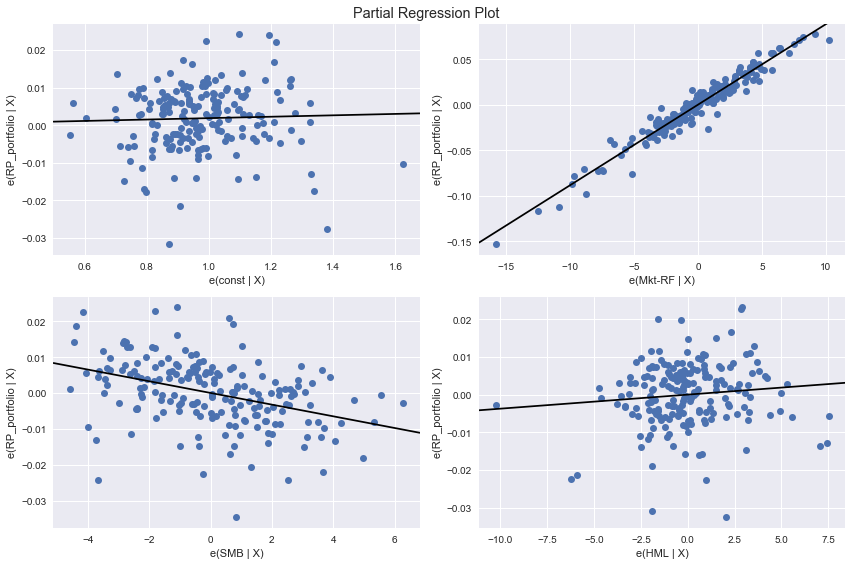

                            OLS Regression Results                            
Dep. Variable:           RP_portfolio   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1108.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):          3.37e-119
Time:                        22:01:08   Log-Likelihood:                 643.81
No. Observations:                 192   AIC:                            -1280.
Df Residuals:                     188   BIC:                            -1267.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.985      0.0

In [89]:
# split dependent and independent variable
y_df = df["RP_portfolio"]
X_df = df[['Mkt-RF','SMB','HML']]

# Add a constant to the independent value
X1_df = sm.add_constant(X_df)

# make regression model 
model_df = sm.OLS(y_df, X1_df)

# fit model and print results
results_df = model_df.fit()

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results_df, fig = fig)
fig.savefig('fama3reg1.png')
plt.show()


print(results_df.summary())
results_df.save("fama3reg.pickle")

### 4.2.2 Alpha and Beta of S&P500 ETF

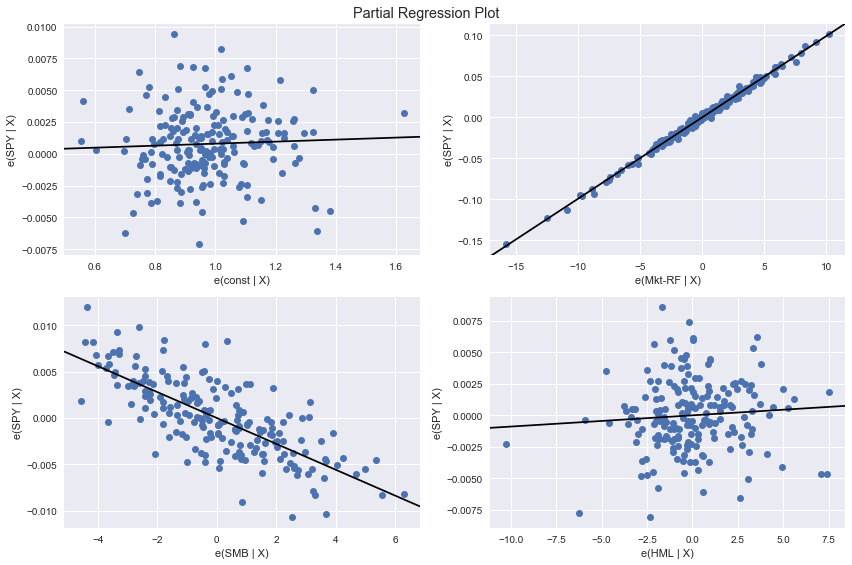

                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.291e+04
Date:                Sun, 29 Apr 2018   Prob (F-statistic):          2.24e-217
Time:                        22:01:12   Log-Likelihood:                 857.44
No. Observations:                 192   AIC:                            -1707.
Df Residuals:                     188   BIC:                            -1694.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      3.852      0.0

In [90]:
# split dependent and independent variable
y_df = df["SPY"]
X_df = df[['Mkt-RF','SMB','HML']]

# Add a constant to the independent value
X1_df = sm.add_constant(X_df)

# make regression model 
model_df = sm.OLS(y_df, X1_df)

# fit model and print results
results_df = model_df.fit()

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results_df, fig = fig)
plt.show()

print(results_df.summary())

In [91]:
df = df.reset_index()

## 4.3 Monthly Return Pair Plots of S&P500 sectors

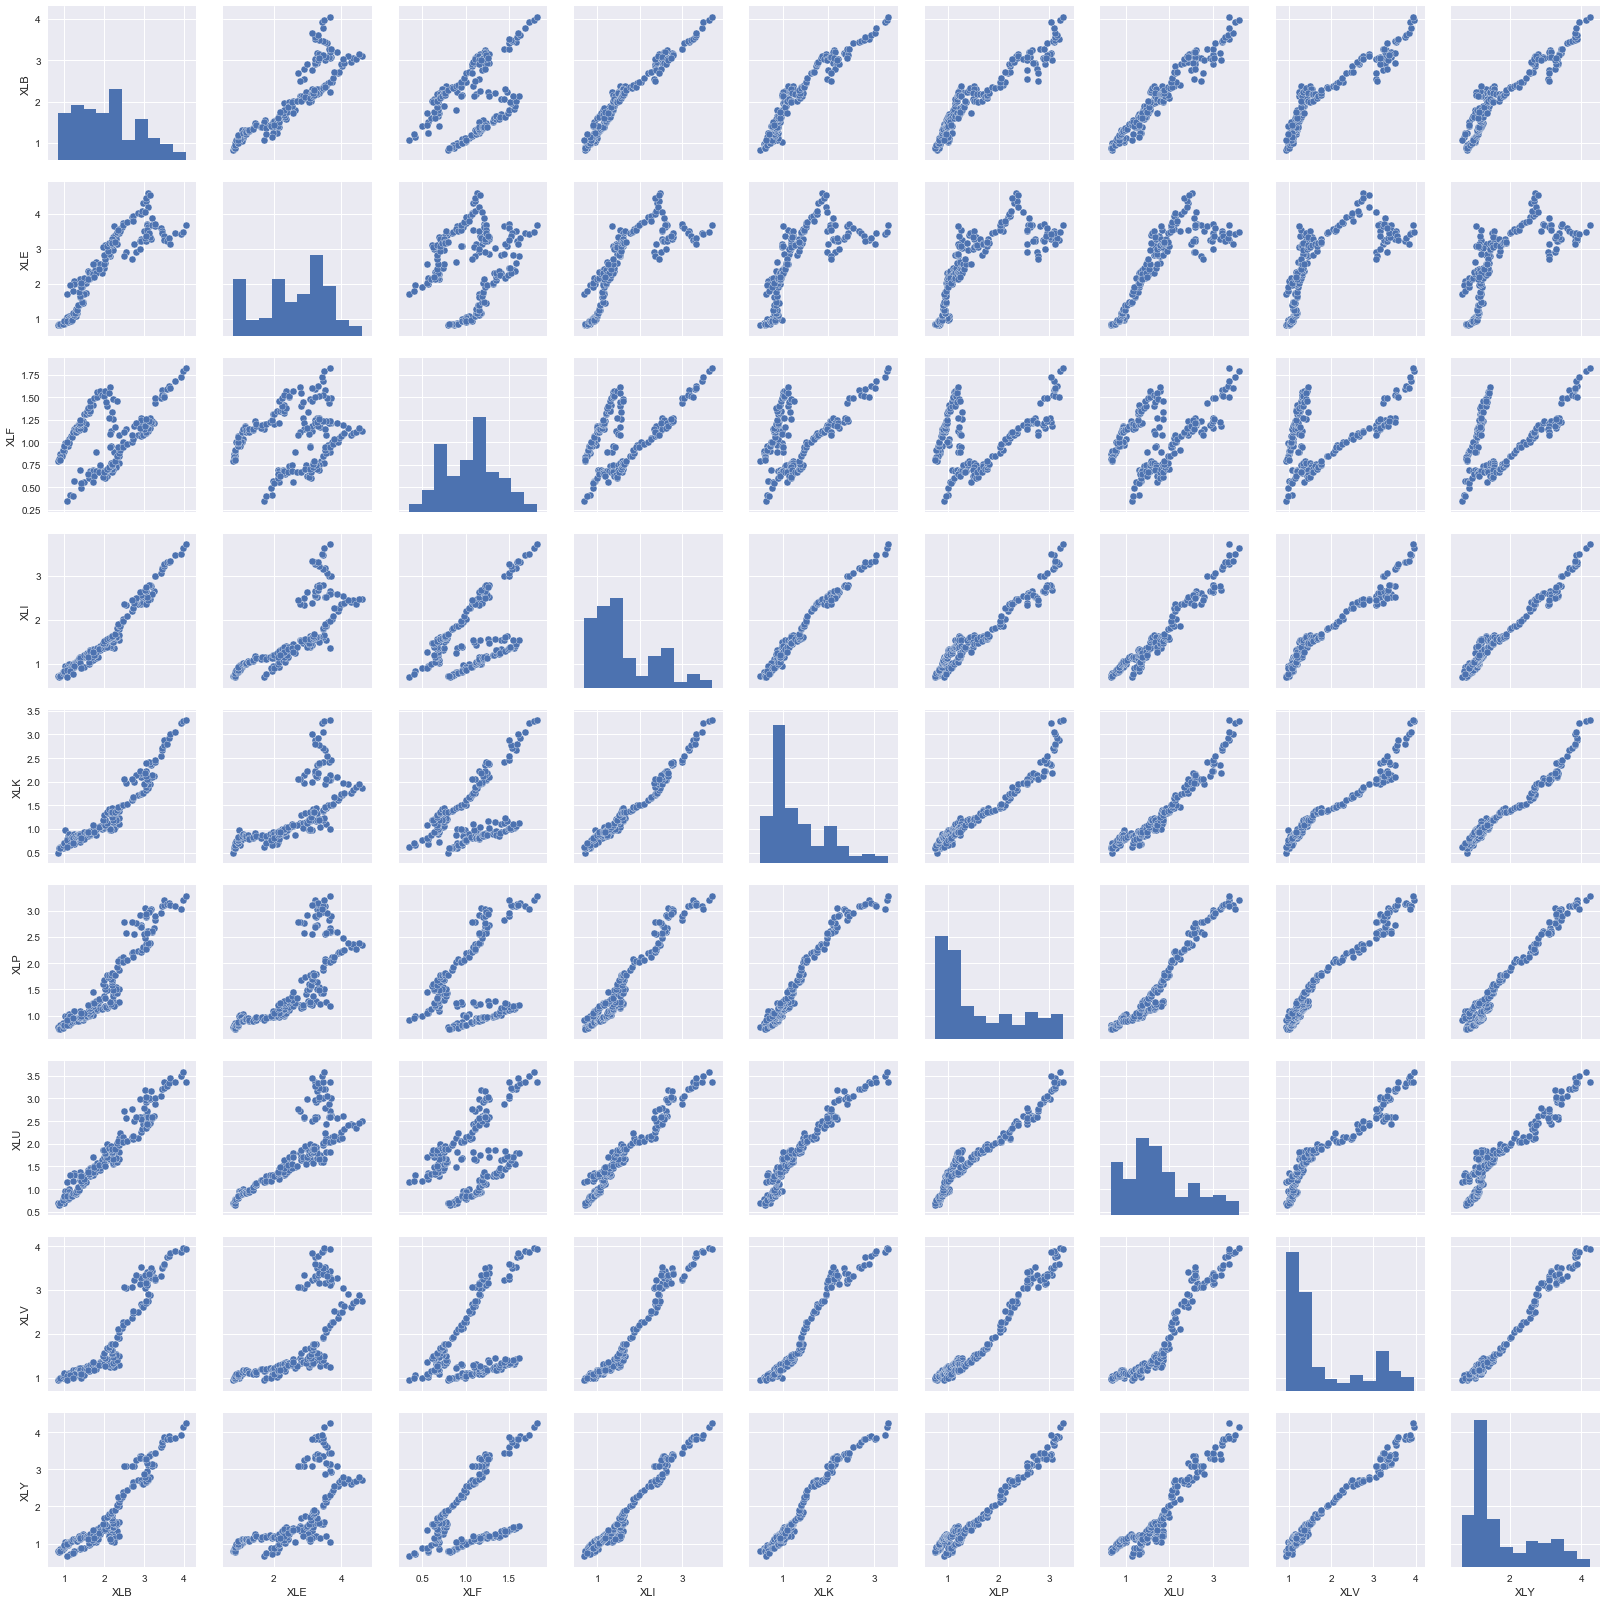

In [92]:
pairplot_tks = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

sns.set(style='darkgrid')
df_snsM = np.cumprod(1 + df.loc[:, tuple(pairplot_tks)])

sns.pairplot(df_snsM)

## 4.4 RP Portfolio Weight Plots

In [3]:
import vincent

In [93]:
df.head()

,date,level_0,index,SPY,XLB,XLE,XLF,XLI,XLK,XLP,...,XLK_wt,XLP_wt,XLU_wt,XLV_wt,XLY_wt,RP_portfolio,Mkt-RF,SMB,HML,RF
0,2002-01-01,24,24,-0.009799,0.023343,-0.035581,-0.011407,-0.063177,-0.010833,-0.006693,...,0.085139,0.220917,0.158681,0.092640,0.090041,-0.013364,-1.44,1.19,3.31,0.14
1,2002-02-01,25,25,-0.017936,0.052920,0.034175,-0.017308,0.025048,-0.129907,0.021007,...,0.084405,0.214783,0.157848,0.091487,0.097140,0.006496,-2.29,-1.10,2.50,0.13
2,2002-03-01,26,26,0.033297,0.030725,0.088465,0.066125,0.027125,0.049090,0.016096,...,0.065745,0.250901,0.171826,0.088444,0.092275,0.041023,4.24,4.24,1.10,0.13
3,2002-04-01,27,27,-0.058156,-0.047237,-0.035999,-0.025414,-0.069016,-0.120905,-0.037165,...,0.061387,0.228027,0.192901,0.083960,0.100303,-0.044987,-5.20,5.94,3.93,0.15
4,2002-05-01,28,28,-0.005934,0.049579,-0.017594,-0.003023,0.004337,-0.041470,-0.011142,...,0.059880,0.224957,0.185980,0.087779,0.102202,-0.003452,-1.38,-3.22,1.71,0.14


In [94]:
v_df  = df[['date','XLB_wt', 'XLE_wt', 'XLF_wt', 'XLI_wt', 'XLK_wt', 'XLP_wt', 'XLU_wt', 'XLV_wt', 'XLY_wt']]
v_df= v_df.set_index('date')

In [95]:
v_df.head()

,XLB_wt,XLE_wt,XLF_wt,XLI_wt,XLK_wt,XLP_wt,XLU_wt,XLV_wt,XLY_wt
date,,,,,,,,,
2002-01-01,0.082405,0.108419,0.089559,0.072199,0.085139,0.220917,0.158681,0.092640,0.090041
2002-02-01,0.087986,0.104165,0.089021,0.073164,0.084405,0.214783,0.157848,0.091487,0.097140
2002-03-01,0.084933,0.091094,0.088562,0.066220,0.065745,0.250901,0.171826,0.088444,0.092275
2002-04-01,0.080272,0.088478,0.097978,0.066693,0.061387,0.228027,0.192901,0.083960,0.100303
2002-05-01,0.080320,0.089886,0.101818,0.067178,0.059880,0.224957,0.185980,0.087779,0.102202


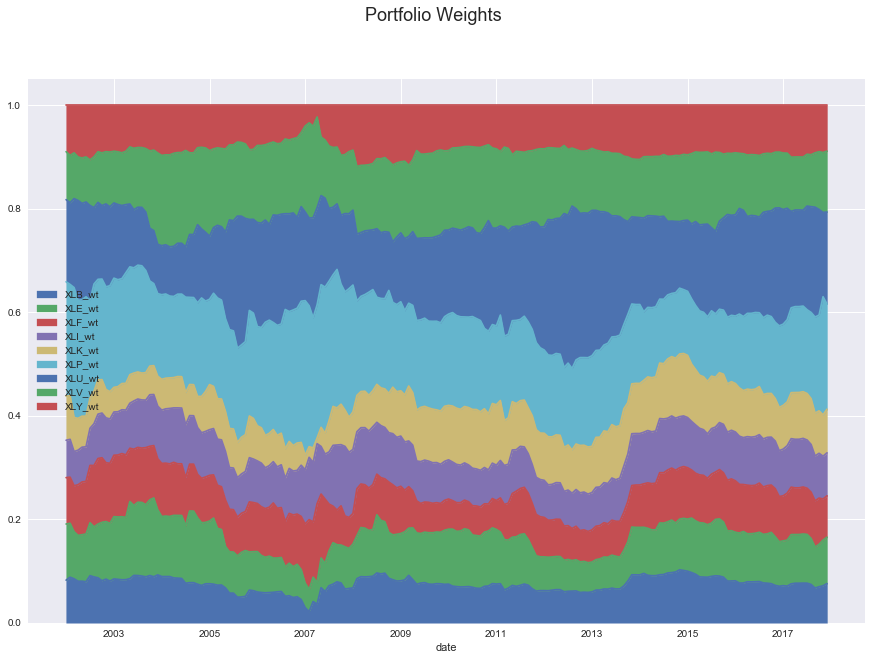

In [97]:
plt.figure()
plt.rcParams['figure.figsize'] = (15,10)
v_df.plot.area()
plt.legend(loc='best')
plt.suptitle('Portfolio Weights', fontsize=18)
axes = plt.plot()
plt.savefig('RPweights1.png')

## 4.5 Cumulative Returns

In [98]:
rt_df = df.loc[:,('date','SPY', 'RP_portfolio')].set_index('date')

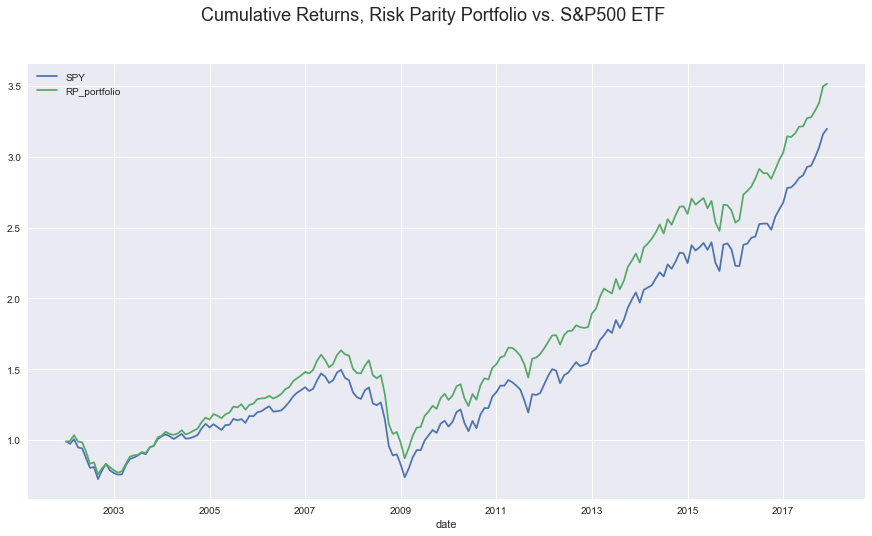

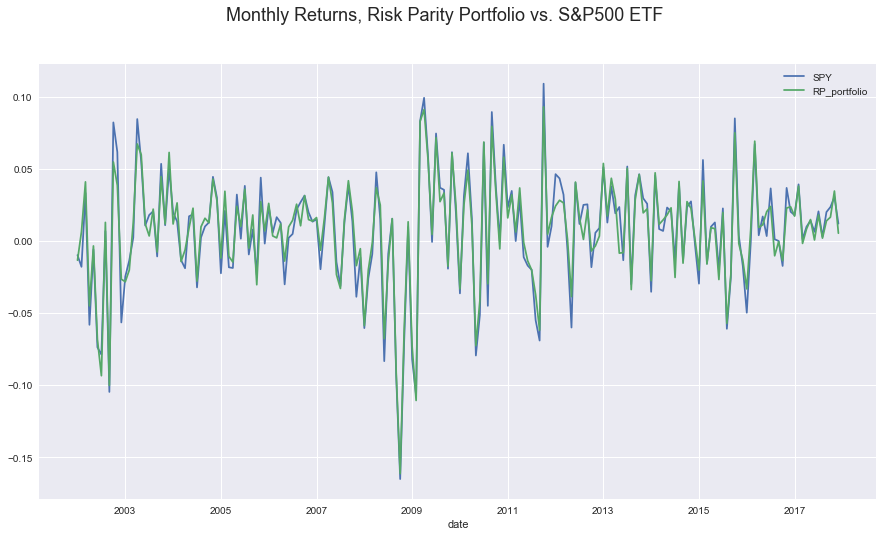

In [99]:
plt.figure()
plt.rcParams['figure.figsize'] = (15, 8)

np.cumprod(1 + rt_df.loc[:, ('SPY', 'RP_portfolio')]).plot()
plt.suptitle('Cumulative Returns, Risk Parity Portfolio vs. S&P500 ETF', fontsize=18)
plt.savefig('Cum_rt.png')
rt_df.loc[:,('SPY', 'RP_portfolio')].plot()
plt.legend()
plt.suptitle('Monthly Returns, Risk Parity Portfolio vs. S&P500 ETF', fontsize=18)
plt.savefig('Mon_rt.png')


In [100]:
from statsmodels.regression.linear_model import OLSResults
new_results = OLSResults.load("fama3reg.pickle")

In [101]:
print(new_results.summary())

                            OLS Regression Results                            
Dep. Variable:           RP_portfolio   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1108.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):          3.37e-119
Time:                        22:01:48   Log-Likelihood:                 643.81
No. Observations:                 192   AIC:                            -1280.
Df Residuals:                     188   BIC:                            -1267.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.985      0.0

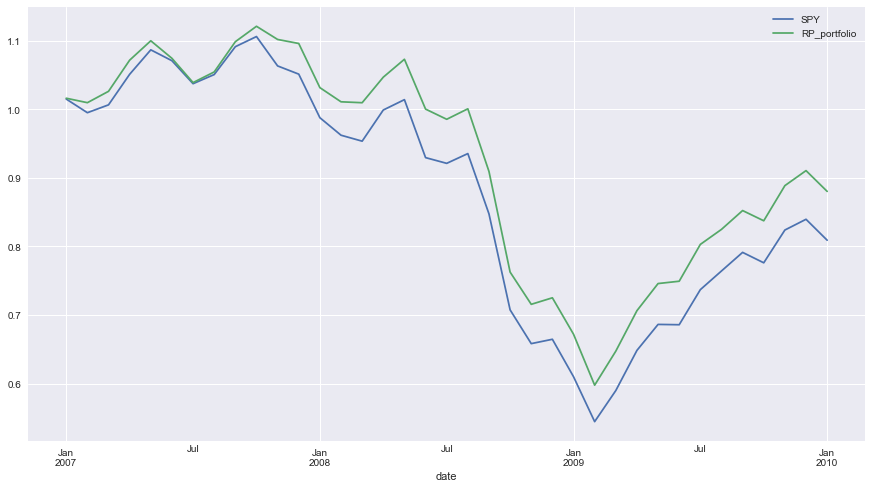

In [102]:
np.cumprod(1 + rt_df.loc['2007-01':'2010-01', ('SPY', 'RP_portfolio')]).plot()
plt.savefig('Cum_crisis.png')

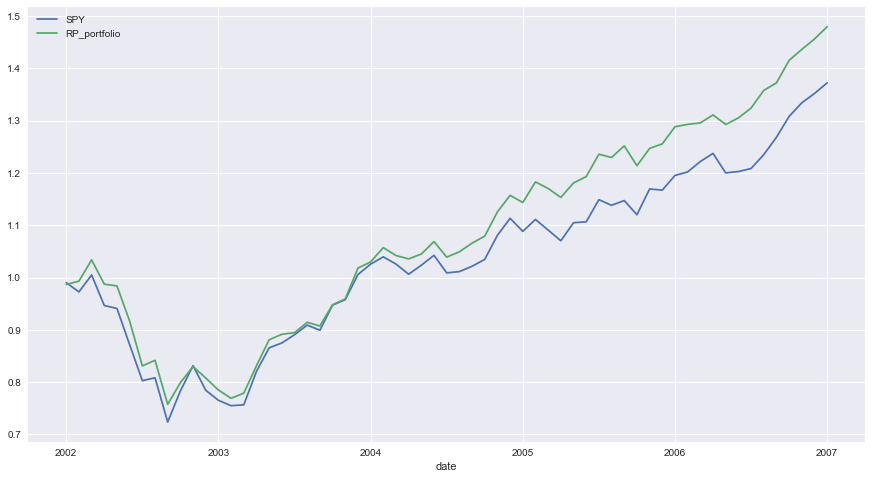

In [103]:
np.cumprod(1 + rt_df.loc['2002-01':'2007-01', ('SPY', 'RP_portfolio')]).plot()
plt.savefig('Cum_first5.png')

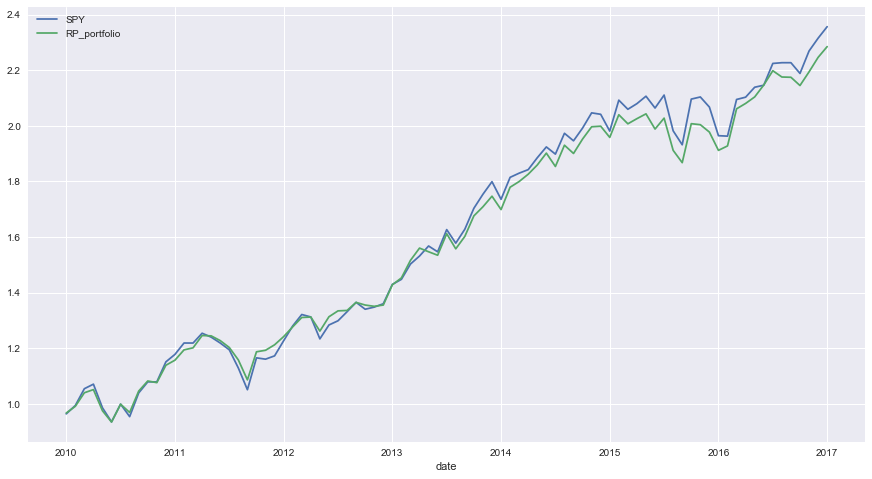

In [104]:
np.cumprod(1 + rt_df.loc['2010-01':'2017-01', ('SPY', 'RP_portfolio')]).plot()
plt.savefig('Cum_last7.png')